In [2]:
#Funções de risco e de retorno de carteiras
portfolio_sd_t <- function(sd, cov, weight){
  stopifnot(length(sd) > 1, is.matrix(cov), length(sd) == length(weight))
  for(i in 1:(length(sd)-1)){
    for(j in (i+1):length(sd)){
      n <- sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2)
      m <- sum(2*weight[i]*weight[j]*cov[i,j])
      sd <- sqrt(sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2+
                       2*weight[i]*weight[j]*cov[i,j]))
      return(sd)
    }
  }
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns) > 1){
    mean <- apply(returns,2,mean, na.rm = T)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [3]:
options(warn = -1, scipen = 999)
pacotes <- c("dplyr", "tidyr","ggplot2","tidyquant","pracma","rmgarch","rugarch")
for(i in pacotes){
    suppressPackageStartupMessages({
        library(i, character.only = T)
    })
}

In [72]:
#Ações escolhidas
acoes <- c("VVAR3.SA","MGLU3.SA","CSNA3.SA","TOTS3.SA",
           "IRBR3.SA","WEGE3.SA")
reta <- tq_get(acoes, from = "2014-01-04") %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = dailyReturn) %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit

In [73]:
year <- lubridate::year(dplyr::first(reta$date))
month <- lubridate::month(dplyr::first(reta$date))
day <- lubridate::day(dplyr::first(reta$date))

In [74]:
reta_ts <- ts(reta[,2:ncol(reta)], start = c(year,month,day), frequency = 252)

In [75]:
multspec <- multispec(replicate(length(acoes),
                                ugarchspec(variance.model = list(garchOrder = c(1,1)))))
multf <- multifit(multispec = multspec, data = reta_ts)
multfor <- multiforecast(multf, n.ahead = 1)
spec1 <- dccspec(uspec = multspec, dccOrder = c(1,1), distribution = "mvnorm")
fit1 <- dccfit(spec1, data = reta_ts, fit = multf, fit.control = list(eval.se = T))
fore <- dccforecast(fit = fit1, n.ahead = 1)

In [76]:
#Matriz de covariância
cov1 <- rcov(fit1)
cov <- cov1[,,dim(cov1)[3]]
cov_f <- rcov(fore)
cov_f <- cov_f[[1]]
cov_f <- cov_f[1:length(acoes),1:length(acoes),1]

In [77]:
#Desvio das ações
sd <- matrix(0, nrow = length(acoes))
sd_f <- matrix(0, nrow = length(acoes))
for(i in 1:nrow(sd)){
  sd[[i]] <- dplyr::last(multf@fit[[i]]@fit[["sigma"]])
  sd_f[[i]] <- multfor@forecast[[i]]@forecast[["sigmaFor"]]
}
rownames(sd) <- sort(acoes)
rownames(sd_f) <- sort(acoes)
sd_a <- sd*sqrt(252)
sd_a_f <- sd_f*sqrt(252)

In [78]:
#Calculando o retorno esperado
retornos_a <- tq_get(acoes, from = Sys.Date()-365*3) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly", fill = 0) %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns") %>%
  na.fill(fill = 0)

`summarise()` regrouping output by 'year' (override with `.groups` argument)



In [79]:
#Nº de simulações de carteiras a se fazer
n_sim <- 30000
pesos <- matrix(0,length(acoes),n_sim)
pesos <- apply(pesos,2,rexp,0.001)
pesos <- apply(pesos,2,function(x)x/sum(x))

In [80]:
#Escolha se prefere o risco atual ou a previsão de risco para 1 período (sd ou sd_f)
start <- Sys.time()
riscos <- apply(pesos, 2, portfolio_sd_t, sd = sd_f, cov = cov_f)*sqrt(252)
retornos <- apply(pesos, 2, portfolio_return, returns = retornos_a[,2:ncol(retornos_a)])
end <- Sys.time()
end-start

Time difference of 5.233404 secs

In [81]:
#Retorno médio das ações
retorno_med <- retornos_a %>%
  data.frame %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media")

`summarise()` ungrouping output (override with `.groups` argument)



In [82]:
#Sharpe
tx_livre_risco <- 0.02
data <- data.frame(riscos = riscos, retornos = retornos, sharpe = (retornos-tx_livre_risco)/riscos)

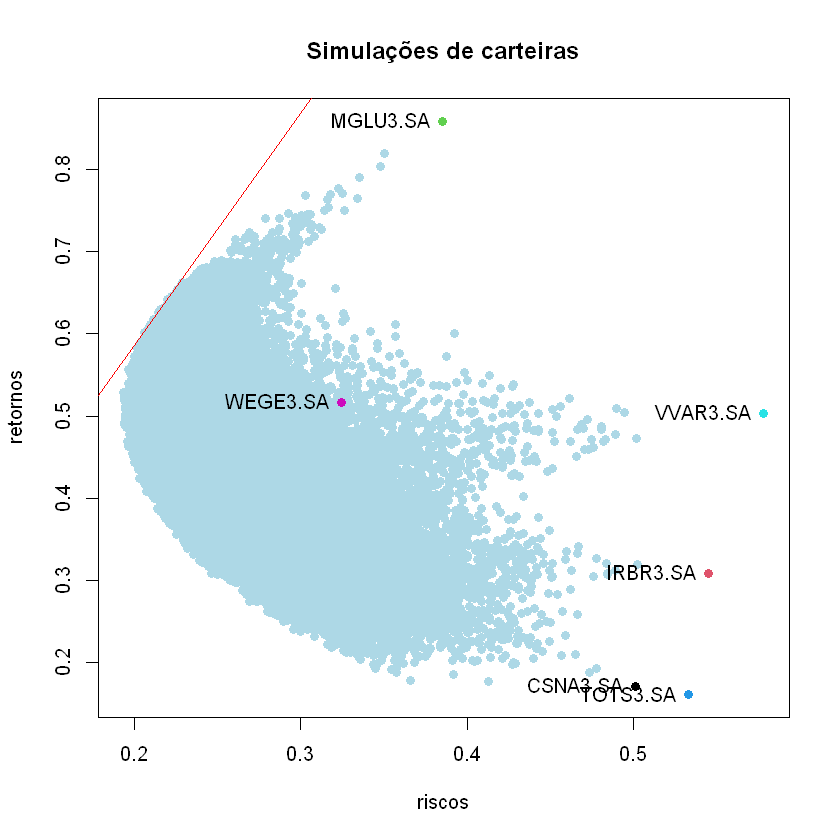

In [88]:
plot(riscos, retornos, pch = 16, col = "lightblue",xlim = c(min(riscos), max(sd_a_f)),
    ylim = c(min(retorno_med), max(retorno_med)), main = "Simulações de carteiras")
points(x = sd_a_f, y = retorno_med, col = 1:ncol(retorno_med), pch = 16)
text(x = sd_a_f, y = retorno_med, labels = colnames(retorno_med), pos = 2)
abline(a = tx_livre_risco, b = max(data$sharpe), col = "red")
abline(h = 0,v = 0, lty = 2)

In [84]:
sharpe <- max(data$sharpe)
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data$retornos)
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data$riscos)
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     2.828464

Retorno Máximo 
     0.8190644

Risco Mínimo 
   0.1938765

In [85]:
#Somente ver a linha que tem o maior sharpe
positivo <- data$sharpe == sharpe
show(data[positivo,])

        riscos  retornos   sharpe
7739 0.2113116 0.6176873 2.828464


## A linha do data.frame "data" equivale a coluna da matriz de pesos

In [86]:
#Pesos em % da melhor carteira
pesos_efi <- round(pesos[,7739]*100,2)
names(pesos_efi) <- sort(acoes)
print(pesos_efi)

CSNA3.SA IRBR3.SA MGLU3.SA TOTS3.SA VVAR3.SA WEGE3.SA 
    4.24     4.61    41.72     4.44    12.62    32.38 


In [87]:
#Carteira eficiente com arredondamento de 3 casas decimais
pesos_ef <- round(pesos[,7739],3)
risco_ef <- portfolio_sd_t(sd = sd, cov = cov, weight = pesos_ef)*sqrt(252)
ret_ef <- portfolio_return(returns = retornos_a[,2:ncol(retornos_a)], weight = pesos_ef)
cart_ef <- data.frame(Risco = risco_ef, Retorno = ret_ef, Sharpe = (ret_ef-tx_livre_risco)/risco_ef)
cart_ef

Risco,Retorno,Sharpe
<dbl>,<dbl>,<dbl>
0.214172,0.6173712,2.789212
